# Creation of dataframe for gravity model

- join on cityname
- create city dataframe (nodes)
- create separate city-pairs dataframes (basically edges)
- calculate distances

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import os
import re
from tqdm.notebook import tqdm
import unidecode
from collections import Counter
from shapely.geometry import Point, LineString, Polygon

In [2]:
INDIR = "../../input"
OUTDIR = "../../output"
DATADIR = "../../../../data"
FILE_cities = "List_of_cities_300k.csv"
FILE_coords = "euro-global-map-shp/data/FullEurope/BuiltupP.shp" #path/to/shapefile

## Calculate distances
- Planar or Geodesic distance
- Join the pairs dataset

In [3]:
fp = os.path.join(INDIR, "city_coordinates.shp")
gdf = gpd.read_file(fp)

In [4]:
gdf.head()

,id_MUA,Mua,Mua_en,Mua_fr,SizeMUA1k,CC,geometry
0,NL01410,Utrecht,Utrecht,Utrecht,390,NL,POINT (5.11148 52.09863)
1,NL01354,Eindhoven,Eindhoven,Eindhoven,316,NL,POINT (5.47234 51.45709)
2,NL01331,Amsterdam,Amsterdam,Amsterdam,1052,NL,POINT (4.87429 52.37074)
3,NL01403,Rotterdam,Rotterdam,Rotterdam,1025,NL,POINT (4.47374 51.92364)
4,PL01510,Poznan,Poznan,Poznan,679,PL,POINT (16.91751 52.40734)


<AxesSubplot:>

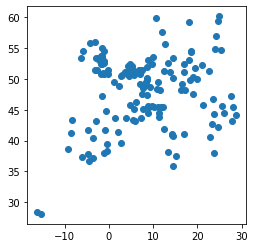

In [5]:
gdf.plot()

In [6]:
gdf.geometry[0].distance(gdf.geometry[4])

11.810063106973496

In [7]:
gdf.crs

<Geographic 2D CRS: EPSG:4258>
Name: ETRS89
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: Europe - onshore and offshore: Albania; Andorra; Austria; Belgium; Bosnia and Herzegovina; Bulgaria; Croatia; Cyprus; Czechia; Denmark; Estonia; Faroe Islands; Finland; France; Germany; Gibraltar; Greece; Hungary; Ireland; Italy; Kosovo; Latvia; Liechtenstein; Lithuania; Luxembourg; Malta; Moldova; Monaco; Montenegro; Netherlands; North Macedonia; Norway including Svalbard and Jan Mayen; Poland; Portugal; Romania; San Marino; Serbia; Slovakia; Slovenia; Spain; Sweden; Switzerland; United Kingdom (UK) including Channel Islands and Isle of Man; Vatican City State.
- bounds: (-16.1, 32.88, 40.18, 84.73)
Datum: European Terrestrial Reference System 1989 ensemble
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

### Option 1:
Calculate distance on projected coordinates. This *will* result in destortion. (Especially considering how far north we are). Somewhat minimized by using a suitable projection. (I believe this to be, EPSG: 3035 - ETRS89-extended / LAEA Europe). 

In [8]:
gdf = gdf.to_crs('EPSG:3035')

In [9]:
gdf.crs

<Derived Projected CRS: EPSG:3035>
Name: ETRS89-extended / LAEA Europe
Axis Info [cartesian]:
- Y[north]: Northing (metre)
- X[east]: Easting (metre)
Area of Use:
- name: Europe - European Union (EU) countries and candidates. Europe - onshore and offshore: Albania; Andorra; Austria; Belgium; Bosnia and Herzegovina; Bulgaria; Croatia; Cyprus; Czechia; Denmark; Estonia; Faroe Islands; Finland; France; Germany; Gibraltar; Greece; Hungary; Iceland; Ireland; Italy; Kosovo; Latvia; Liechtenstein; Lithuania; Luxembourg; Malta; Monaco; Montenegro; Netherlands; North Macedonia; Norway including Svalbard and Jan Mayen; Poland; Portugal including Madeira and Azores; Romania; San Marino; Serbia; Slovakia; Slovenia; Spain including Canary Islands; Sweden; Switzerland; Turkey; United Kingdom (UK) including Channel Islands and Isle of Man; Vatican City State.
- bounds: (-35.58, 24.6, 44.83, 84.73)
Coordinate Operation:
- name: Europe Equal Area 2001
- method: Lambert Azimuthal Equal Area
Datum: Europ

In [10]:
gdf.geometry[0].distance(gdf.geometry[1])/ 1000

75.61913916162662

In [11]:
gdf.head()

,id_MUA,Mua,Mua_en,Mua_fr,SizeMUA1k,CC,geometry
0,NL01410,Utrecht,Utrecht,Utrecht,390,NL,POINT (3986294.355 3232207.546)
1,NL01354,Eindhoven,Eindhoven,Eindhoven,316,NL,POINT (4006534.020 3159347.337)
2,NL01331,Amsterdam,Amsterdam,Amsterdam,1052,NL,POINT (3972221.509 3263538.886)
3,NL01403,Rotterdam,Rotterdam,Rotterdam,1025,NL,POINT (3941243.288 3215906.046)
4,PL01510,Poznan,Poznan,Poznan,679,PL,POINT (4790943.558 3277681.393)


### Join the pairs dataset

In [12]:
# load the pairs dataset
file_name = "citypairs_english_20220603.csv"
fp = os.path.join(OUTDIR, file_name)
pairs_df_en = pd.read_csv(fp, sep=';')

In [13]:
pairs_df_en.head()

,city_A,city_B,collocation_en
0,Paris,London,21874.0
1,Paris,Madrid,3394.0
2,Paris,Berlin,7899.0
3,Paris,Milan,3342.0
4,Paris,Barcelona,2397.0


In [14]:
# remove accents from names to enable join
gdf['Mua_en'] = [unidecode.unidecode(city) for city in gdf['Mua_en']]

In [15]:
# subset for join
gdf_min = gdf[['Mua_en', 'SizeMUA1k', 'geometry', 'CC']]

In [16]:
# join first city
joined_df = pd.merge(pairs_df_en, gdf_min, how='left', left_on = 'city_A', right_on = 'Mua_en')

In [17]:
joined_df.shape

(11175, 7)

In [18]:
joined_df.head()

,city_A,city_B,collocation_en,Mua_en,SizeMUA1k,geometry,CC
0,Paris,London,21874.0,Paris,9591,POINT (3760015.368 2889948.695),FR
1,Paris,Madrid,3394.0,Paris,9591,POINT (3760015.368 2889948.695),FR
2,Paris,Berlin,7899.0,Paris,9591,POINT (3760015.368 2889948.695),FR
3,Paris,Milan,3342.0,Paris,9591,POINT (3760015.368 2889948.695),FR
4,Paris,Barcelona,2397.0,Paris,9591,POINT (3760015.368 2889948.695),FR


In [19]:
# join second city
joined_df = pd.merge(joined_df, gdf_min, how='left', left_on = 'city_B', right_on = 'Mua_en', suffixes=('_A', '_B'))

In [20]:
joined_df.head()

,city_A,city_B,collocation_en,Mua_en_A,SizeMUA1k_A,geometry_A,CC_A,Mua_en_B,SizeMUA1k_B,geometry_B,CC_B
0,Paris,London,21874.0,Paris,9591,POINT (3760015.368 2889948.695),FR,London,8256,POINT (3623219.566 3204183.954),UK
1,Paris,Madrid,3394.0,Paris,9591,POINT (3760015.368 2889948.695),FR,Madrid,4955,POINT (3161798.324 2030549.871),ES
2,Paris,Berlin,7899.0,Paris,9591,POINT (3760015.368 2889948.695),FR,Berlin,3776,POINT (4552085.153 3273010.955),DE
3,Paris,Milan,3342.0,Paris,9591,POINT (3760015.368 2889948.695),FR,Milan,3698,POINT (4256391.191 2484870.286),IT
4,Paris,Barcelona,2397.0,Paris,9591,POINT (3760015.368 2889948.695),FR,Barcelona,3659,POINT (3664331.118 2067683.425),ES


In [21]:
joined_df.shape

(11175, 11)

In [22]:
# distance Paris-London
joined_df.geometry_A[0].distance(joined_df.geometry_B[0])/ 1000

342.7198407546638

In [33]:
# calculate planar distance, divided by 1000 to get km
def city_dist(row):
    dist = row['geometry_A'].distance(row['geometry_B']) / 1000
    return dist

In [24]:
# add column with the distances
joined_df['distance'] = joined_df.apply(city_dist, axis = 1)

In [34]:
joined_df.head()

,city_A,city_B,collocation_en,Mua_en_A,SizeMUA1k_A,geometry_A,CC_A,Mua_en_B,SizeMUA1k_B,geometry_B,CC_B,distance
0,Paris,London,21874.0,Paris,9591,POINT (3760015.368 2889948.695),FR,London,8256,POINT (3623219.566 3204183.954),UK,342.719841
1,Paris,Madrid,3394.0,Paris,9591,POINT (3760015.368 2889948.695),FR,Madrid,4955,POINT (3161798.324 2030549.871),ES,1047.105521
2,Paris,Berlin,7899.0,Paris,9591,POINT (3760015.368 2889948.695),FR,Berlin,3776,POINT (4552085.153 3273010.955),DE,879.835916
3,Paris,Milan,3342.0,Paris,9591,POINT (3760015.368 2889948.695),FR,Milan,3698,POINT (4256391.191 2484870.286),IT,640.685161
4,Paris,Barcelona,2397.0,Paris,9591,POINT (3760015.368 2889948.695),FR,Barcelona,3659,POINT (3664331.118 2067683.425),ES,827.813778


In [35]:
# add the french collocations
file_name = "citypairs_french_20220603.csv"
fp = os.path.join(OUTDIR, file_name)
pairs_df_fr = pd.read_csv(fp, sep=';')

joined_df['collocation_fr'] = pairs_df_fr['collocation_fr'].copy()

In [36]:
gravity_df = joined_df[['city_A', 'city_B', 'SizeMUA1k_A', 'SizeMUA1k_B', 'CC_A', 'CC_B', 
                        'distance', 'collocation_en', 'collocation_fr', 'geometry_A', 'geometry_B']]

# gravity_df = joined_df[['city_A', 'city_B', 'SizeMUA1k_A', 'SizeMUA1k_B', 'CC_A', 'CC_B', 
#                         'distance', 'collocation_en', 'collocation_fr']]

In [37]:
# replace SizeMUA1k with POP
gravity_df.columns = gravity_df.columns.str.replace('SizeMUA1k', 'POP')

In [38]:
gravity_df

,city_A,city_B,POP_A,POP_B,CC_A,CC_B,distance,collocation_en,collocation_fr,geometry_A,geometry_B
0,Paris,London,9591,8256,FR,UK,342.719841,21874.0,10733.0,POINT (3760015.368 2889948.695),POINT (3623219.566 3204183.954)
1,Paris,Madrid,9591,4955,FR,ES,1047.105521,3394.0,2404.0,POINT (3760015.368 2889948.695),POINT (3161798.324 2030549.871)
2,Paris,Berlin,9591,3776,FR,DE,879.835916,7899.0,4723.0,POINT (3760015.368 2889948.695),POINT (4552085.153 3273010.955)
3,Paris,Milan,9591,3698,FR,IT,640.685161,3342.0,2713.0,POINT (3760015.368 2889948.695),POINT (4256391.191 2484870.286)
4,Paris,Barcelona,9591,3659,FR,ES,827.813778,2397.0,1696.0,POINT (3760015.368 2889948.695),POINT (3664331.118 2067683.425)
...,...,...,...,...,...,...,...,...,...,...,...
11170,Brasov,Valletta,307,301,RO,MT,1434.980050,0.0,0.0,POINT (5529295.231 2631657.414),POINT (4732026.336 1438539.627)
11171,Brasov,Ghent,307,300,RO,BE,1719.502407,1.0,0.0,POINT (5529295.231 2631657.414),POINT (3881703.383 3123724.104)
11172,Bonn,Valletta,306,301,DE,MT,1746.824968,4.0,0.0,POINT (4116262.831 3073236.167),POINT (4732026.336 1438539.627)
11173,Bonn,Ghent,306,300,DE,BE,239.931587,22.0,14.0,POINT (4116262.831 3073236.167),POINT (3881703.383 3123724.104)


In [39]:
# # save the no dummies version
# file_name = "gravity_df_noDUM.csv"
# fp = os.path.join(OUTDIR, file_name)
# gravity_df.to_csv(fp, index = False, sep = ";")

### Dummies
- ~~Border~~
- ~~French / English sphere (do I want to differentiate between single & double?)~~
- Multiple names for 1 city (e.g. Lyons/Lyon, Goteborg/Gothenburg, etc)
- Also a name (Florence, Sofia)
- Also a word (Lens, Nice)
- Multiple cities with the same name (Frankfurt, London, Valence, Birmingham, etc.) (perhaps put a lower limit in there, like the other place must have at least x inhabitants)

In [40]:
# border dummy
gravity_df['border_DUM'] = np.where(gravity_df['CC_A'] != gravity_df['CC_B'], 1, 0)


/var/folders/15/8v892gvj639_bp8s5ftm80400000gn/T/ipykernel_88322/1267033339.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gravity_df['border_DUM'] = np.where(gravity_df['CC_A'] != gravity_df['CC_B'], 1, 0)


In [41]:
# French sphere Dummy
gravity_df['FR_DUM'] = np.where((gravity_df['CC_A'] == 'FR')|
                            (gravity_df['CC_B'] == 'FR')|
                            (gravity_df['CC_A'] == 'BE')|
                            (gravity_df['CC_B'] == 'BE'), 1, 0)

# is 1 if both cities in the french sphere
gravity_df['FR_int'] = np.where((gravity_df['FR_DUM'] == 1) & (gravity_df['border_DUM'] == 0), 1, 0)

# french speaking swiss cities?!!! --> change earlier to include lang1 and lang2 from the open maps dataset

In [42]:
# English sphere Dummy
gravity_df['EN_DUM'] = np.where((gravity_df['CC_A'] == 'UK')|
                            (gravity_df['CC_B'] == 'UK')|
                            (gravity_df['CC_A'] == 'IE')|
                            (gravity_df['CC_B'] == 'IE'), 1, 0)

# is 1 if both cities in the english sphere
gravity_df['EN_int'] = np.where((gravity_df['EN_DUM'] == 1) & (gravity_df['border_DUM'] == 0), 1, 0)

In [50]:
df = gravity_df[['city_A', 'city_B', 'POP_A', 'POP_B', 'distance',
                         'border_DUM', 'FR_DUM', 'FR_int', 'EN_DUM', 'EN_int',
                         'collocation_en', 'collocation_fr', 'geometry_A', 'geometry_B']]



In [58]:
# replace collocation with col
df.columns = df.columns.str.replace('collocation', 'col')

In [59]:
df.head(10)

,city_A,city_B,POP_A,POP_B,distance,border_DUM,FR_DUM,FR_int,EN_DUM,EN_int,col_en,col_fr,geometry_A,geometry_B,col_prop_fr,col_prop_en
0,Paris,London,9591,8256,342.719841,1,1,0,1,0,21874.0,10733.0,POINT (3760015.368 2889948.695),POINT (3623219.566 3204183.954),1.787238,2.095814
1,Paris,Madrid,9591,4955,1047.105521,1,1,0,0,0,3394.0,2404.0,POINT (3760015.368 2889948.695),POINT (3161798.324 2030549.871),0.400309,0.325189
2,Paris,Berlin,9591,3776,879.835916,1,1,0,0,0,7899.0,4723.0,POINT (3760015.368 2889948.695),POINT (4552085.153 3273010.955),0.786465,0.756827
3,Paris,Milan,9591,3698,640.685161,1,1,0,0,0,3342.0,2713.0,POINT (3760015.368 2889948.695),POINT (4256391.191 2484870.286),0.451763,0.320207
4,Paris,Barcelona,9591,3659,827.813778,1,1,0,0,0,2397.0,1696.0,POINT (3760015.368 2889948.695),POINT (3664331.118 2067683.425),0.282415,0.229664
5,Paris,Athens,9591,3331,2096.025767,1,1,0,0,0,1249.0,957.0,POINT (3760015.368 2889948.695),POINT (5528465.495 1764822.852),0.159358,0.119670
6,Paris,Rome,9591,2532,1108.950763,1,1,0,0,0,6821.0,6116.0,POINT (3760015.368 2889948.695),POINT (4528992.127 2090920.199),1.018424,0.653541
7,Paris,Birmingham,9591,2363,501.095554,1,1,0,1,0,525.0,171.0,POINT (3760015.368 2889948.695),POINT (3518316.783 3328900.343),0.028475,0.050302
8,Paris,Lisbon,9591,2315,1444.535501,1,1,0,0,0,1071.0,807.0,POINT (3760015.368 2889948.695),POINT (2665767.616 1946919.177),0.134380,0.102616
9,Paris,Naples,9591,2308,1293.563826,1,1,0,0,0,1180.0,979.0,POINT (3760015.368 2889948.695),POINT (4682976.240 1983609.575),0.163021,0.113059


In [52]:
df.shape

(11175, 14)

### Add Normalized Counts

## Normalize Collocations
- count total nr of paragraphs for each language
- calculate proportion of possible connections that connect

In [60]:
# fr paragraph count = 6005355
# en paragraph count = 10436996
# see count paragraph notebook
fr_count = 6005355
en_count = 10436996

df['col_prop_fr'] = [(collocation / fr_count)*1000 for collocation in df['col_fr']]
df['col_prop_en'] = [(collocation / en_count)*1000 for collocation in df['col_en']]

In [61]:
df.head()

,city_A,city_B,POP_A,POP_B,distance,border_DUM,FR_DUM,FR_int,EN_DUM,EN_int,col_en,col_fr,geometry_A,geometry_B,col_prop_fr,col_prop_en
0,Paris,London,9591,8256,342.719841,1,1,0,1,0,21874.0,10733.0,POINT (3760015.368 2889948.695),POINT (3623219.566 3204183.954),1.787238,2.095814
1,Paris,Madrid,9591,4955,1047.105521,1,1,0,0,0,3394.0,2404.0,POINT (3760015.368 2889948.695),POINT (3161798.324 2030549.871),0.400309,0.325189
2,Paris,Berlin,9591,3776,879.835916,1,1,0,0,0,7899.0,4723.0,POINT (3760015.368 2889948.695),POINT (4552085.153 3273010.955),0.786465,0.756827
3,Paris,Milan,9591,3698,640.685161,1,1,0,0,0,3342.0,2713.0,POINT (3760015.368 2889948.695),POINT (4256391.191 2484870.286),0.451763,0.320207
4,Paris,Barcelona,9591,3659,827.813778,1,1,0,0,0,2397.0,1696.0,POINT (3760015.368 2889948.695),POINT (3664331.118 2067683.425),0.282415,0.229664


In [62]:
# def en_fr_diff(row):
#     diff = row['col_prop_en'] - row['col_prop_fr']
#     return diff

In [63]:
# # if the relation is stronger in english >0 and if it is stronger in french than it is <0
# df['en_fr_diff'] = df.apply(en_fr_diff, axis = 1)
# df.head()

In [64]:
# df['en_fr_diff'].plot.hist()

In [65]:
# COLS = ['city_A', 'city_B', 'col_prop_en', 'col_prop_fr', 'en_fr_diff']

# # more french
# df[COLS].sort_values(by='en_fr_diff').head(20)

In [66]:
# # more english
# df[COLS].sort_values(by='en_fr_diff').tail(20)

So is London more strongly related in English because of self-focus bias OR is it more strongly related because of a difference in disambiguation issues?

<font color='red'>Maybe shouldn't do a sum difference, but like a proportional difference?. fr / en?</font>

In [67]:
# French occurences as proportion of English occurences
def fr_en_prop(row):
    if (row['col_prop_fr'] == 0) | (row['col_prop_en'] == 0):
        prop = np.nan
    else: 
        prop = row['col_prop_fr'] / row['col_prop_en']
        
    return prop

# if the french relation is the same size as the english prop = 1 if french is greater >1 if english is greater <1
df['fr_en_prop'] = df.apply(fr_en_prop, axis = 1)
df.head()

,city_A,city_B,POP_A,POP_B,distance,border_DUM,FR_DUM,FR_int,EN_DUM,EN_int,col_en,col_fr,geometry_A,geometry_B,col_prop_fr,col_prop_en,fr_en_prop
0,Paris,London,9591,8256,342.719841,1,1,0,1,0,21874.0,10733.0,POINT (3760015.368 2889948.695),POINT (3623219.566 3204183.954),1.787238,2.095814,0.852766
1,Paris,Madrid,9591,4955,1047.105521,1,1,0,0,0,3394.0,2404.0,POINT (3760015.368 2889948.695),POINT (3161798.324 2030549.871),0.400309,0.325189,1.231004
2,Paris,Berlin,9591,3776,879.835916,1,1,0,0,0,7899.0,4723.0,POINT (3760015.368 2889948.695),POINT (4552085.153 3273010.955),0.786465,0.756827,1.039161
3,Paris,Milan,9591,3698,640.685161,1,1,0,0,0,3342.0,2713.0,POINT (3760015.368 2889948.695),POINT (4256391.191 2484870.286),0.451763,0.320207,1.410848
4,Paris,Barcelona,9591,3659,827.813778,1,1,0,0,0,2397.0,1696.0,POINT (3760015.368 2889948.695),POINT (3664331.118 2067683.425),0.282415,0.229664,1.229687


In [68]:
COLS = ['city_A', 'city_B', 'col_prop_en', 'col_prop_fr', 'fr_en_prop']

# if the french relation is greater >1 if english is greater <1
df[COLS][~df.fr_en_prop.isna()].sort_values(by='fr_en_prop').tail(20)

,city_A,city_B,col_prop_en,col_prop_fr,fr_en_prop
10037,Toulon,Charleroi,0.000096,0.001499,15.641534
3428,Valencia,Lyon,0.006611,0.114065,17.253544
1435,Lisbon,Charleroi,0.000096,0.001665,17.379482
9693,Rouen,Grenoble,0.003737,0.064942,17.379482
8290,Malaga,Augsburg,0.000096,0.001665,17.379482
5559,Antwerp,Grenoble,0.000192,0.003497,18.248456
4407,Seville,Dortmund,0.000192,0.003497,18.248456
5240,Lille,Toulon,0.001916,0.036467,19.030533
6842,Bremen,Rouen,0.000096,0.001832,19.117430
7432,Bordeaux,Valletta,0.000096,0.001832,19.117430


In [77]:
#  english is greater >1 if french is greater <1
df['en_fr_prop'] = [1/fr_en_prop for fr_en_prop in df.fr_en_prop]

# display the ones with the biggest difference
COLS = ['city_A', 'city_B', 'col_prop_en', 'col_prop_fr', 'en_fr_prop']

#  english is greater >1 if french is greater <1
df[COLS][~df.en_fr_prop.isna()].sort_values(by='en_fr_prop').tail(20)

,city_A,city_B,col_prop_en,col_prop_fr,en_fr_prop
3498,Valencia,Grenoble,0.001341,0.110901,0.012095
10011,Toulon,Lens,0.000479,0.016652,0.028770
8013,Toulouse,Valletta,0.000096,0.003330,0.028770
7995,Toulouse,Granada,0.000479,0.014154,0.033847
3494,Valencia,Rouen,0.000287,0.007327,0.039231
11059,Montpellier,Eindhoven,0.000096,0.002331,0.041099
10012,Toulon,Augsburg,0.000096,0.002331,0.041099
2609,Vienna,Grenoble,0.004599,0.108070,0.042556
8390,Nantes,Charleroi,0.000096,0.002165,0.044261
5496,Marseille,A Coruna,0.000096,0.002165,0.044261


Edinburgh Brighton different. Strong relation might be because they both host large Fringe Festivals? However in French things named after Edinburgh e.g. the festival maintain the English spelling, while the city itself has a different spelling (Édimbourg). This might be leading to Edinburgh suffering in particular from under-emphasis. 

In [99]:
df.columns

Index(['city_A', 'city_B', 'POP_A', 'POP_B', 'distance', 'border_DUM',
       'FR_DUM', 'FR_int', 'EN_DUM', 'EN_int', 'col_en', 'col_fr',
       'geometry_A', 'geometry_B', 'col_prop_fr', 'col_prop_en', 'fr_en_prop',
       'en_fr_prop'],
      dtype='object')

In [100]:
gravity_df = df[['city_A', 'city_B', 'POP_A', 'POP_B', 'distance', 'border_DUM',
                 'FR_DUM', 'FR_int', 'EN_DUM', 'EN_int', 'col_en', 'col_fr',
                 'col_prop_fr', 'col_prop_en', 'fr_en_prop','en_fr_prop']]

In [101]:
# # save the dummies version
# file_name = "gravity_df_DUM.csv"
# fp = os.path.join(OUTDIR, file_name)
# gravity_df.to_csv(fp, index = False, sep = ";")

## Create Edges

In [105]:
df.head()

,city_A,city_B,POP_A,POP_B,distance,border_DUM,FR_DUM,FR_int,EN_DUM,EN_int,col_en,col_fr,geometry_A,geometry_B,col_prop_fr,col_prop_en,fr_en_prop,en_fr_prop
0,Paris,London,9591,8256,342.719841,1,1,0,1,0,21874.0,10733.0,POINT (3760015.368 2889948.695),POINT (3623219.566 3204183.954),1.787238,2.095814,0.852766,1.172655
1,Paris,Madrid,9591,4955,1047.105521,1,1,0,0,0,3394.0,2404.0,POINT (3760015.368 2889948.695),POINT (3161798.324 2030549.871),0.400309,0.325189,1.231004,0.812345
2,Paris,Berlin,9591,3776,879.835916,1,1,0,0,0,7899.0,4723.0,POINT (3760015.368 2889948.695),POINT (4552085.153 3273010.955),0.786465,0.756827,1.039161,0.962315
3,Paris,Milan,9591,3698,640.685161,1,1,0,0,0,3342.0,2713.0,POINT (3760015.368 2889948.695),POINT (4256391.191 2484870.286),0.451763,0.320207,1.410848,0.708794
4,Paris,Barcelona,9591,3659,827.813778,1,1,0,0,0,2397.0,1696.0,POINT (3760015.368 2889948.695),POINT (3664331.118 2067683.425),0.282415,0.229664,1.229687,0.813215


In [106]:
# creates a shapely line object between the two city points
def create_edge(row):
    edge = LineString([row['geometry_A'], row['geometry_B']])
    return edge

In [107]:
# test line creation
df['geometry'] = df.apply(create_edge, axis = 1)

/Users/brecht/opt/anaconda3/envs/citynet/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


In [109]:
df.head()

,city_A,city_B,POP_A,POP_B,distance,border_DUM,FR_DUM,FR_int,EN_DUM,EN_int,col_en,col_fr,geometry_A,geometry_B,col_prop_fr,col_prop_en,fr_en_prop,en_fr_prop,geometry
0,Paris,London,9591,8256,342.719841,1,1,0,1,0,21874.0,10733.0,POINT (3760015.368 2889948.695),POINT (3623219.566 3204183.954),1.787238,2.095814,0.852766,1.172655,LINESTRING (3760015.3675289643 2889948.6954368...
1,Paris,Madrid,9591,4955,1047.105521,1,1,0,0,0,3394.0,2404.0,POINT (3760015.368 2889948.695),POINT (3161798.324 2030549.871),0.400309,0.325189,1.231004,0.812345,LINESTRING (3760015.3675289643 2889948.6954368...
2,Paris,Berlin,9591,3776,879.835916,1,1,0,0,0,7899.0,4723.0,POINT (3760015.368 2889948.695),POINT (4552085.153 3273010.955),0.786465,0.756827,1.039161,0.962315,LINESTRING (3760015.3675289643 2889948.6954368...
3,Paris,Milan,9591,3698,640.685161,1,1,0,0,0,3342.0,2713.0,POINT (3760015.368 2889948.695),POINT (4256391.191 2484870.286),0.451763,0.320207,1.410848,0.708794,LINESTRING (3760015.3675289643 2889948.6954368...
4,Paris,Barcelona,9591,3659,827.813778,1,1,0,0,0,2397.0,1696.0,POINT (3760015.368 2889948.695),POINT (3664331.118 2067683.425),0.282415,0.229664,1.229687,0.813215,LINESTRING (3760015.3675289643 2889948.6954368...


In [110]:
gdf.crs

<Derived Projected CRS: EPSG:3035>
Name: ETRS89-extended / LAEA Europe
Axis Info [cartesian]:
- Y[north]: Northing (metre)
- X[east]: Easting (metre)
Area of Use:
- name: Europe - European Union (EU) countries and candidates. Europe - onshore and offshore: Albania; Andorra; Austria; Belgium; Bosnia and Herzegovina; Bulgaria; Croatia; Cyprus; Czechia; Denmark; Estonia; Faroe Islands; Finland; France; Germany; Gibraltar; Greece; Hungary; Iceland; Ireland; Italy; Kosovo; Latvia; Liechtenstein; Lithuania; Luxembourg; Malta; Monaco; Montenegro; Netherlands; North Macedonia; Norway including Svalbard and Jan Mayen; Poland; Portugal including Madeira and Azores; Romania; San Marino; Serbia; Slovakia; Slovenia; Spain including Canary Islands; Sweden; Switzerland; Turkey; United Kingdom (UK) including Channel Islands and Isle of Man; Vatican City State.
- bounds: (-35.58, 24.6, 44.83, 84.73)
Coordinate Operation:
- name: Europe Equal Area 2001
- method: Lambert Azimuthal Equal Area
Datum: Europ

In [111]:
# transform into a geodataframe
edge_df = gpd.GeoDataFrame(df, columns = df.columns, geometry = 'geometry', crs = gdf.crs)


<AxesSubplot:>

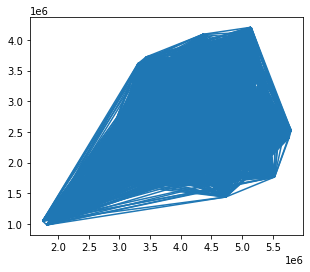

In [112]:
edge_df.plot()

In [113]:
edge_df = edge_df[['city_A', 'city_B', 'POP_A', 'POP_B', 'distance', 'border_DUM',
                 'FR_DUM', 'FR_int', 'EN_DUM', 'EN_int', 'col_en', 'col_fr',
                 'col_prop_fr', 'col_prop_en', 'fr_en_prop','en_fr_prop', 'geometry']]



In [115]:
edge_df.crs

<Derived Projected CRS: EPSG:3035>
Name: ETRS89-extended / LAEA Europe
Axis Info [cartesian]:
- Y[north]: Northing (metre)
- X[east]: Easting (metre)
Area of Use:
- name: Europe - European Union (EU) countries and candidates. Europe - onshore and offshore: Albania; Andorra; Austria; Belgium; Bosnia and Herzegovina; Bulgaria; Croatia; Cyprus; Czechia; Denmark; Estonia; Faroe Islands; Finland; France; Germany; Gibraltar; Greece; Hungary; Iceland; Ireland; Italy; Kosovo; Latvia; Liechtenstein; Lithuania; Luxembourg; Malta; Monaco; Montenegro; Netherlands; North Macedonia; Norway including Svalbard and Jan Mayen; Poland; Portugal including Madeira and Azores; Romania; San Marino; Serbia; Slovakia; Slovenia; Spain including Canary Islands; Sweden; Switzerland; Turkey; United Kingdom (UK) including Channel Islands and Isle of Man; Vatican City State.
- bounds: (-35.58, 24.6, 44.83, 84.73)
Coordinate Operation:
- name: Europe Equal Area 2001
- method: Lambert Azimuthal Equal Area
Datum: Europ

In [116]:
# save the edges map
fp = os.path.join(OUTDIR, "cooccurence_map.shp")
edge_df.to_file(fp)

/Users/brecht/opt/anaconda3/envs/citynet/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/var/folders/15/8v892gvj639_bp8s5ftm80400000gn/T/ipykernel_88322/2496268329.py:3: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  edge_df.to_file(fp)


In [117]:
edge_df.head()

,city_A,city_B,POP_A,POP_B,distance,border_DUM,FR_DUM,FR_int,EN_DUM,EN_int,col_en,col_fr,col_prop_fr,col_prop_en,fr_en_prop,en_fr_prop,geometry
0,Paris,London,9591,8256,342.719841,1,1,0,1,0,21874.0,10733.0,1.787238,2.095814,0.852766,1.172655,"LINESTRING (3760015.368 2889948.695, 3623219.5..."
1,Paris,Madrid,9591,4955,1047.105521,1,1,0,0,0,3394.0,2404.0,0.400309,0.325189,1.231004,0.812345,"LINESTRING (3760015.368 2889948.695, 3161798.3..."
2,Paris,Berlin,9591,3776,879.835916,1,1,0,0,0,7899.0,4723.0,0.786465,0.756827,1.039161,0.962315,"LINESTRING (3760015.368 2889948.695, 4552085.1..."
3,Paris,Milan,9591,3698,640.685161,1,1,0,0,0,3342.0,2713.0,0.451763,0.320207,1.410848,0.708794,"LINESTRING (3760015.368 2889948.695, 4256391.1..."
4,Paris,Barcelona,9591,3659,827.813778,1,1,0,0,0,2397.0,1696.0,0.282415,0.229664,1.229687,0.813215,"LINESTRING (3760015.368 2889948.695, 3664331.1..."
